In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

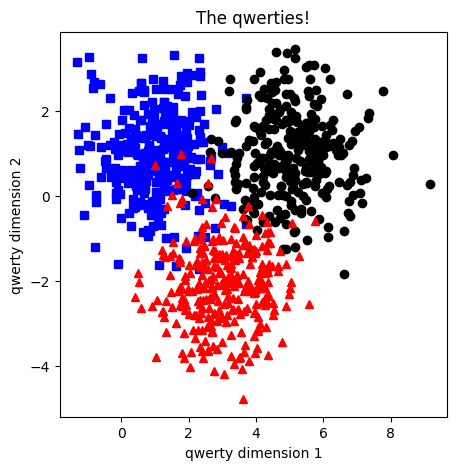

In [3]:
# create data
nPerClust = 300
blur = 1

A = [  1,  1 ]
B = [  5,  1 ]
C = [  3, -2 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1)),1+np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [4]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7)
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

batch = 64
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
for x, y in train_loader:
    print(x.shape, y.shape)

torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2]) torch.Size([64])


In [6]:
test_data.tensors[0].shape[0]

270

In [7]:
len(train_data)

630

In [8]:
len(train_loader)

9

In [14]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(2, 16)
        self.hidden1 = nn.Linear(16,32)
        self.hidden2 = nn.Linear(32,20)
        self.output = nn.Linear(20,3)
    def forward(self, x):
        # doBN is a do batch norm boolean
        x = f.relu(self.input(x))
        x = f.relu(self.hidden1(x))
        x = f.relu(self.hidden2(x))
        x = self.output(x)
        return x

In [15]:
ann = model()
lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ann.parameters(), lr =0.01)

In [16]:
epochs = 1000
def train():
    # initialize loss
    train_acc = []
    test_acc = []
    losses = []
    # triaining
    for i in range(epochs):
        ann.train()
        batchacc = []
        batchloss = []
        for xtrain, ytrain in train_loader:
            yhat = ann(xtrain)
            loss = lossfn(yhat, ytrain)
            batchloss.append(loss.detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # batch accuracy
            batchacc.append(100*torch.mean((torch.argmax(yhat, axis=1) == ytrain).float()).item())
        # train accuracy
        train_acc.append(np.mean(batchacc))
        losses.append(np.mean(batchloss))
        # model evaluation
        ann.eval()
        xtest, ytest = next(iter(test_loader))
        with torch.no_grad():
            pred = ann(xtest)
        test_acc.append(100*torch.mean((torch.argmax(pred, axis=1) == ytest).float()).item())

    return train_acc, test_acc, losses

In [17]:
train_acc, test_acc, losses = train()

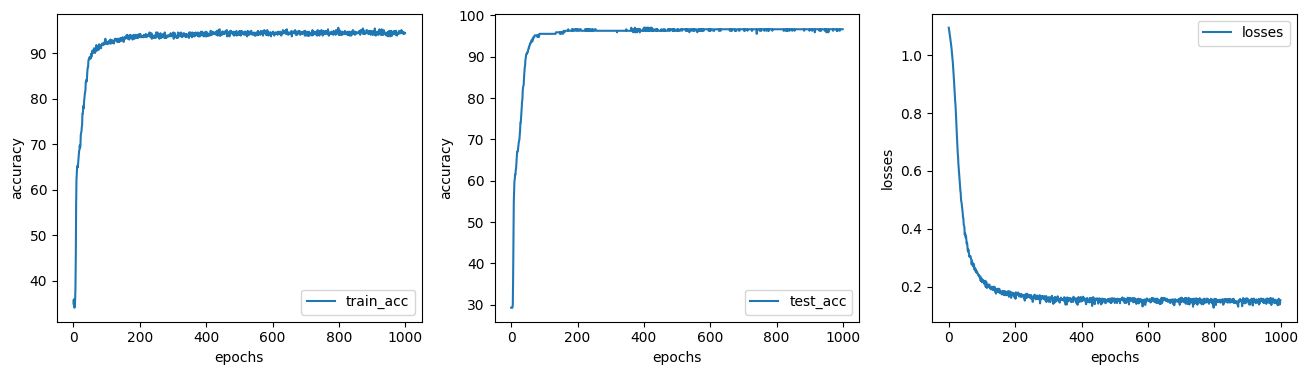

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].plot(range(epochs), train_acc)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')

ax[1].plot(range(epochs), test_acc)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')


ax[2].plot(range(epochs), losses)
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('losses')